# Defining a Network in **PyTorch**

## Multi-layer Perceptron , MNIST

We'll train an MLP to classify an image from the
MNIST Database : http://yann.lecun.com/exdb/mnist/  hand written digit database.

Following are the steps :
1. Load and Visualize the data.
2. Define a neural network.
3. Train the model.
4. Evaluate the performance of our trained model on a test dataset.

**bold text**
**bold text**

In [2]:
# Importing Necesary Libraries
import torch
import numpy as np

## Load and Visualize the data.

Downloading data may take a few minutes and you should see progress as the data is loading.You may also choose to change the batch_size if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.


In [3]:
# The MNIST datasets are hosted on yann. Lecun.com that has moved under CloudFlare
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener (opener)

In [4]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# number of subprocesses to use for data loading
num_workers = 0  # (num_workers) to 0, which means data loading will be done in the main process (no additional worker processes).

# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()    # (transform) to convert the data to torch.FloatTensor

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# prepare data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
# It creates data loaders for both the training and test datasets using the DataLoader class.

100%|██████████| 9912422/9912422 [00:00<00:00, 154574935.47it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 27505834.20it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41699173.94it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 13715283.49it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

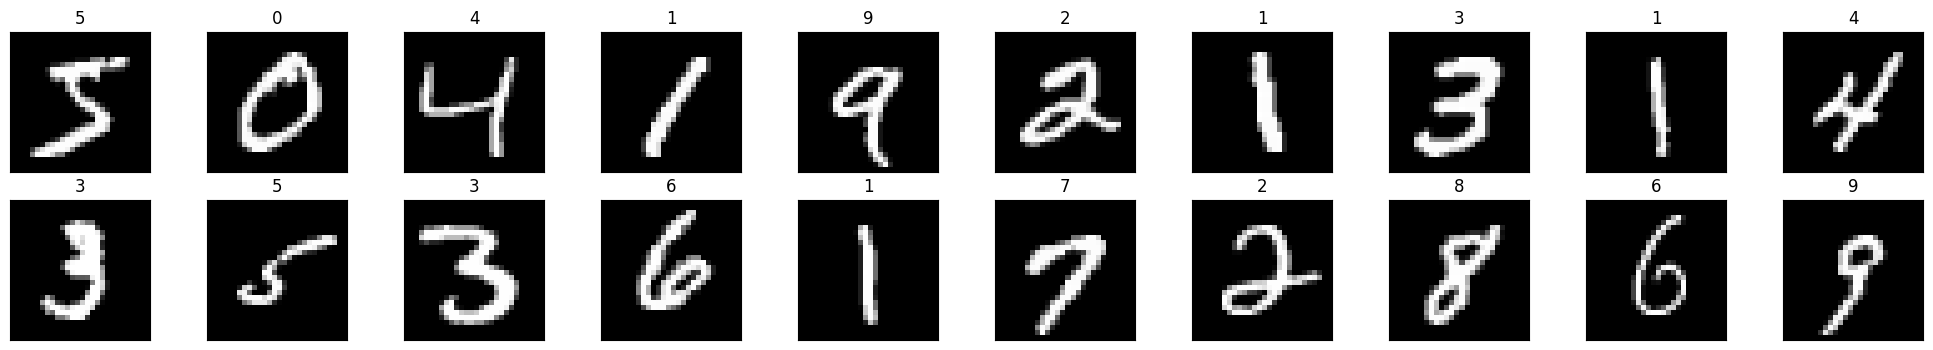

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')  # Set the cmap here
    ax.set_title(str(labels[idx].item()))  # Print out the correct label for each image


## View an image in More Detail

IndexError: ignored

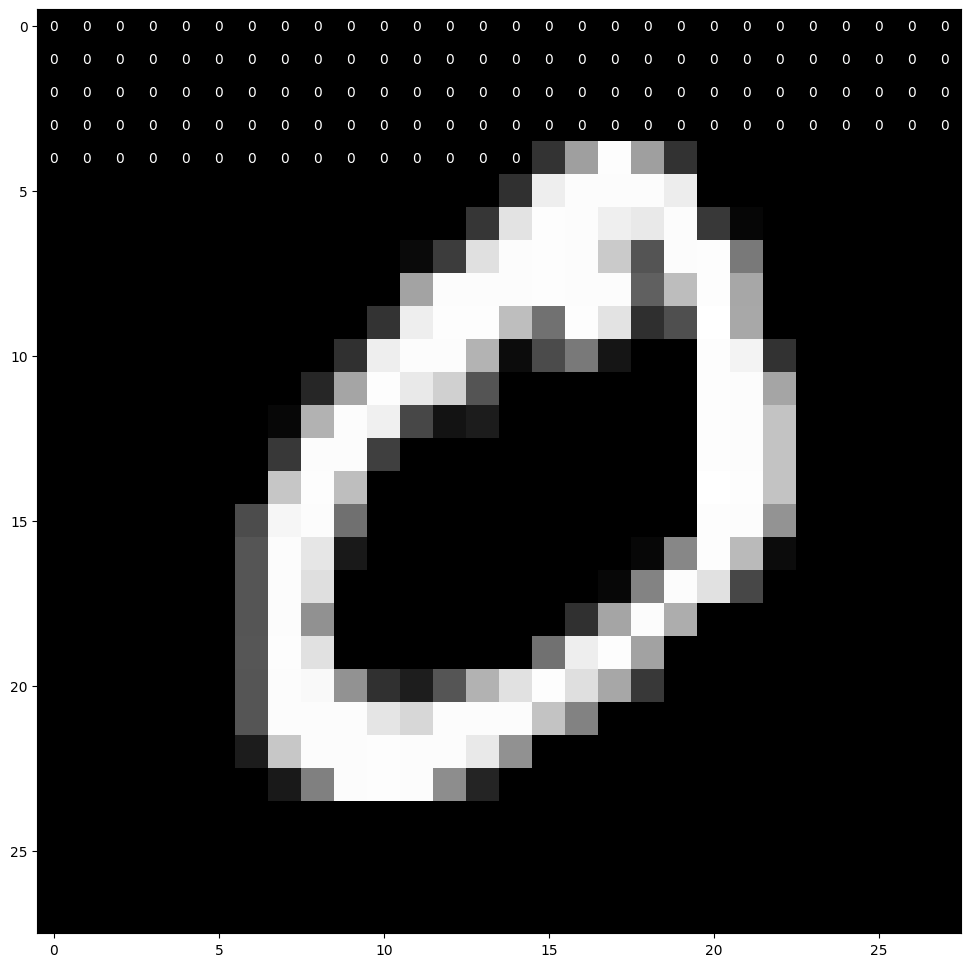

In [ ]:
import numpy as np
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y,2]) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
        horizontalalignment='center',
        verticalalignment='center',
        color='white' if img[x][y]<thresh else 'black')

## Define the Network Architecture

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicstes the clasds scores for an input image. This particuklar example uses two hidden layers and dropout to avoid overfitting.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Net(nn.Module):
    def __init__(self):    # To define any neural network in PyToch you have to define and name any layers that have learned weight vakues in the init function.
        super(Net, self).__init__()

        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512

        # linear layer (784 or 28*28 -> hidden_1)
        self.fc1 = nn.Linear(28 * 28, hidden_1)   # In this case we define fully-connected layer

        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)

        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)

        # dropout layer (p=0.2)
        # dropout prevents overfitting of data

        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # I've made sure to flatten the input image X by using the view () function.
        # -1 i.e this function automatically fit all of the X values into this column shape.



      # Why i used ReLu function here bacause the output of every hidden layer so that those outputs are consistent postive values and finally return the transformed X.

        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))

        # add dropout layer
        x = self.dropout(x)

        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))

        # add dropout layer
        x = self.dropout(x)

        # add output layer
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)


Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


# Specify Loss Function and Optimizer

It's recommened that you use cross-entropy loss for classification. If you look at the documentation(https://pytorch.org/docs/stable/nn.html#loss-functions), you can see that PyTorch's cross entropy function aplies a softmax function to the output layer and then calculates the log loss.


In [ ]:
import torch
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (Stochastic Gradient Descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Train the Network

The steps for Training/learning form a batch of data are described in the comments below:

1. Clear the gradients of ll optimized variables.
2. Forward Pass: Compute predicted outputs by passing to the model.
3. Calculate the loss.
4. Backward Pass: Compute gradient of the loss with respect to model parameters.
5. Perform a single optimization step (parameter update).
6. Update average training loss.

The following loop trains for 50 epochs, take a look at how the values for the training loss decrease over time. we want it to decrease while also avoiding overfitting the training data.

In [ ]:
# Number of epochs to train the model
n_epochs = 50  # Recommend to training between 20-50 epochs.

model.train() # Prep model for training

for epoch in range(n_epochs):
    # Monitor training loss
    train_loss = 0.0


    #############
    # Train the model (batch loop)
    #############
    for data, target in train_loader:
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()

        # After getting the output from trainloader i.e predicted class score we return as a output for forward pass.

        # Forward pass: compute predicted outputs by pasing inputs to the model
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target) # Comparing predicted output and the true labels, the target (these were again gotten from our trainloader), so we comapre a batch of outputs target lables and calculates the cross-entropy loss.

        # Backward pass: compute gradient of the loss with rspect to model parameters
        loss.backward()

        # Perform a single optimization step(parameter update)
        optimizer .step()

        # Update running training loss
        train_loss += loss.item()*data.size(0)


    # Print training statistics
    # Calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_loss
        ))

Epoch: 1 	Training Loss: 0.832665
Epoch: 2 	Training Loss: 0.323955
Epoch: 3 	Training Loss: 0.251299
Epoch: 4 	Training Loss: 0.205022
Epoch: 5 	Training Loss: 0.173292
Epoch: 6 	Training Loss: 0.149726
Epoch: 7 	Training Loss: 0.131953
Epoch: 8 	Training Loss: 0.117089
Epoch: 9 	Training Loss: 0.104697
Epoch: 10 	Training Loss: 0.094865
Epoch: 11 	Training Loss: 0.087294
Epoch: 12 	Training Loss: 0.080369
Epoch: 13 	Training Loss: 0.074756
Epoch: 14 	Training Loss: 0.068741
Epoch: 15 	Training Loss: 0.063067
Epoch: 16 	Training Loss: 0.059997
Epoch: 17 	Training Loss: 0.055394
Epoch: 18 	Training Loss: 0.052186
Epoch: 19 	Training Loss: 0.049488
Epoch: 20 	Training Loss: 0.046509
Epoch: 21 	Training Loss: 0.044017
Epoch: 22 	Training Loss: 0.041579
Epoch: 23 	Training Loss: 0.039079
Epoch: 24 	Training Loss: 0.036827
Epoch: 25 	Training Loss: 0.035231
Epoch: 26 	Training Loss: 0.033626
Epoch: 27 	Training Loss: 0.030746
Epoch: 28 	Training Loss: 0.029697
Epoch: 29 	Training Loss: 0.0

**Test the Trained Network**

Fially, we test our best model on previously unseen test data and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking an its overall loss and accuarcy.

In [ ]:
# Initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = [0.0] * 10
class_total = [0.0] * 10

model.eval()

# Prep model for testing
for data, target in test_loader:
    # Forward pass: Compute predicted outputs by passing inputs to the model
    output = model(data)

    # Calculate the loss
    loss = criterion(output, target)

    # Update the loss
    test_loss += loss.item() * data.size(0)

    # Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)

    # Compare predictions to true label
    correct = pred.eq(target.data.view_as(pred))

    # Calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Calculate and print average test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            int(class_correct[i]), int(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (str(i)))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * sum(class_correct) / sum(class_total),
    int(sum(class_correct)), int(sum(class_total))))


Test Loss: 0.055389

Test Accuracy of     0: 99% (972/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 98% (1013/1032)
Test Accuracy of     3: 98% (991/1010)
Test Accuracy of     4: 98% (969/982)
Test Accuracy of     5: 98% (877/892)
Test Accuracy of     6: 98% (942/958)
Test Accuracy of     7: 98% (1011/1028)
Test Accuracy of     8: 97% (947/974)
Test Accuracy of     9: 97% (988/1009)

Test Accuracy (Overall): 98% (9837/10000)


**Visualize Sample Test Results**

This cell displays test images and their labels in this format. predicted (ground-truth). The text will be green for accuractely classified examples and red for incorrect predictions.

RuntimeError: ignored

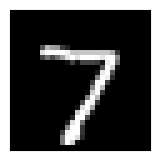

In [ ]:
# Obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Get sample outputs
output = model(images)

# convert output probabilties to predicted class
preds = torch.max(output, 1)

# Prep images for display
images = images.numpy()

# Plot the images in the batch, along with predicted and true labels
# Create a figure with 2 rows and 10 columns (20 plots in total)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())))

plt.show()